In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
data = pd.read_csv('./全部数据/附件1-区域15分钟负荷数据.csv', parse_dates=['数据时间'], index_col=[0])
data

,总有功功率（kw）
数据时间,
2018-01-01 00:00:00,244033.7682
2018-01-01 00:15:00,232720.6402
2018-01-01 00:30:00,231685.6891
2018-01-01 00:45:00,227581.3317
2018-01-01 01:00:00,233482.4269
...,...
2021-08-31 22:45:00,202409.1270
2021-08-31 23:00:00,218576.4635
2021-08-31 23:15:00,200112.5091


In [3]:
# data中时间序列不连续，本来有128544行，但是data只有128156行
# 用重采样的方式将有断点的时间序列变成连续时间序列
data_fill = data.resample('15T').mean()
# 用中位数填充空缺值
data_fill[data_fill.isna().iloc[:,0]] = data.median()

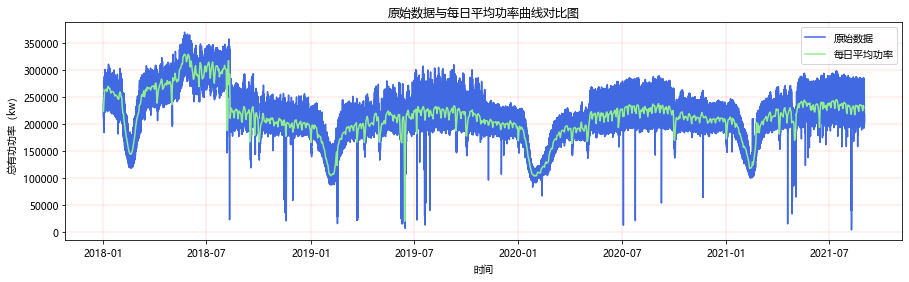

In [4]:
plt.rcParams['font.family'] = ['Microsoft YaHei']
plt.figure(figsize=(15,4))
plt.grid(color = 'tomato', linestyle = '--', linewidth = 0.25)
plt.plot(data_fill, label='原始数据', color='royalblue')
plt.plot(data_fill.resample('D').mean(), label='每日平均功率', color='lightgreen')
plt.title('原始数据与每日平均功率曲线对比图')
plt.ylabel('总有功功率（kw）')
plt.xlabel('时间')
plt.legend()
# plt.savefig('原始数据与每日平均功率曲线对比图.svg')

In [5]:
# 将每天96个时间点的数据减去该天功率的平均数数据，使所有点的的功率变化都在一条水平线上
data_day_mean = data_fill.resample('D').mean().values
data_values = [data_fill.iloc[i + 96*j, 0] - data_day_mean[j][0] for j in range(1339) for i in range(96)]

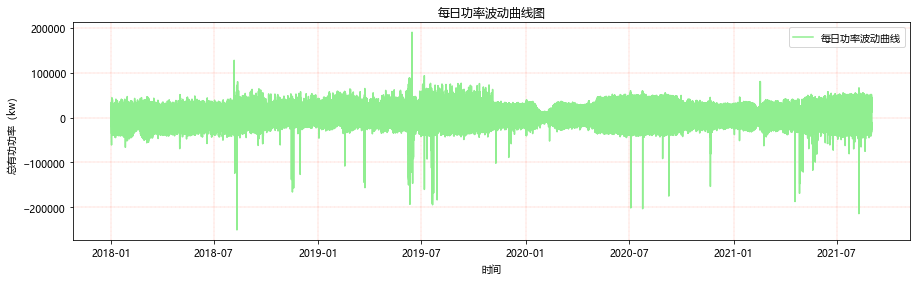

In [6]:
dti = pd.date_range("2018-01-01", periods=128544, freq="15T")
plt.rcParams['font.family'] = ['Microsoft YaHei']
plt.figure(figsize=(15,4))
plt.grid(color = 'tomato', linestyle = '--', linewidth = 0.25)
plt.title('每日功率波动曲线图')
plt.ylabel('总有功功率（kw）')
plt.xlabel('时间')
plt.plot(dti, data_values, color='lightgreen', label='每日功率波动曲线')
plt.legend()
# plt.savefig('每日功率波动曲线图.svg')

In [7]:
# 利用正态分布的3σ原则，得出异常点数目为472
data_values = pd.Series(data_values)
mean = data_values.mean()
std = data_values.std()
rule=(mean-3*std > data_values) | (mean+3*std < data_values)
rule.sum()

362

In [8]:
# 先用中位数填充异常点，使异常点落在大部分取值范围中
data_del_wrong = data_values.copy()
data_del_wrong[rule] = data_values.median()

# 再用滑动平均数去给异常点赋值，使异常点的数值与周围10个点的数值连续
data_del_wrong[rule] = pd.Series(data_del_wrong).rolling(10, center=True).mean()[rule]
data_smooth = pd.Series(data_del_wrong)

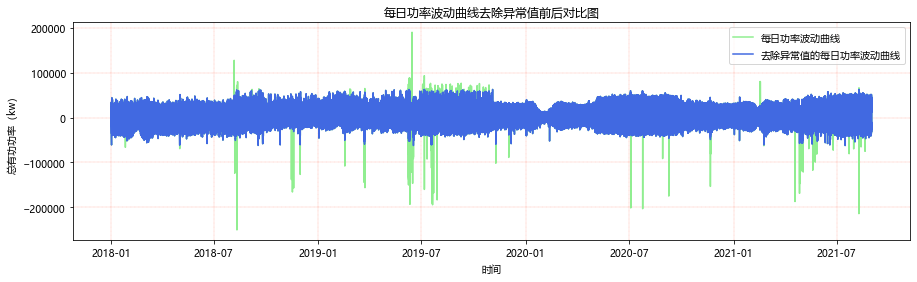

In [9]:
dti = pd.date_range("2018-01-01", periods=128544, freq="15T")
plt.rcParams['font.family'] = ['Microsoft YaHei']
plt.figure(figsize=(15,4))
plt.grid(color = 'tomato', linestyle = '--', linewidth = 0.25)
plt.title('每日功率波动曲线去除异常值前后对比图')
plt.ylabel('总有功功率（kw）')
plt.xlabel('时间')
plt.plot(dti, data_values, color='lightgreen', label='每日功率波动曲线')
plt.plot(dti, data_smooth, color='royalblue', label='去除异常值的每日功率波动曲线')
plt.legend()
plt.savefig('每日功率波动曲线去除异常值前后对比图.svg')

In [10]:
data_smooth = np.asarray(data_smooth)

In [11]:
# 将数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data_smooth.reshape(-1, 1))
data_scaled = scaler.transform(data_smooth.reshape(-1, 1))[:,0]
data_scaled

array([0.66373188, 0.57322189, 0.56494183, ..., 0.26429583, 0.2623204 ,
       0.25126351])

In [12]:
def dataset(data, win_size=96):
    X = []
    Y = []
    for i in range(len(data)-win_size):
        temp_x = data[i:i+win_size]
        temp_y = data[i+win_size]
        X.append(temp_x)
        Y.append(temp_y)
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y

In [13]:
data_x, data_y = dataset(data_scaled, 96)

In [14]:
data_x = np.expand_dims(data_x, axis=1)

In [15]:
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.2, shuffle=False)
model = Sequential()
model.add(LSTM(256, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dense(1, activation='sigmoid'))

In [16]:
model.compile(loss='mse', optimizer='adam')
history = model.fit(train_x, train_y, epochs=18, batch_size=64, validation_split=0.2, shuffle=False)

Epoch 1/18
1285/1285 [==============================] - 8s 4ms/step - loss: 0.0039 - val_loss: 8.3378e-04
Epoch 2/18
1285/1285 [==============================] - 5s 4ms/step - loss: 0.0029 - val_loss: 6.6103e-04
Epoch 3/18
1285/1285 [==============================] - 5s 4ms/step - loss: 0.0027 - val_loss: 5.8920e-04
Epoch 4/18
1285/1285 [==============================] - 5s 4ms/step - loss: 0.0026 - val_loss: 5.5708e-04
Epoch 5/18
1285/1285 [==============================] - 5s 4ms/step - loss: 0.0025 - val_loss: 5.4072e-04
Epoch 6/18
1285/1285 [==============================] - 4s 4ms/step - loss: 0.0025 - val_loss: 5.3005e-04
Epoch 7/18
1285/1285 [==============================] - 4s 3ms/step - loss: 0.0025 - val_loss: 5.2092e-04
Epoch 8/18
1285/1285 [==============================] - 5s 4ms/step - loss: 0.0024 - val_loss: 5.1309e-04
Epoch 9/18
1285/1285 [==============================] - 4s 3ms/step - loss: 0.0024 - val_loss: 5.0486e-04
Epoch 10/18
1285/1285 [=======================

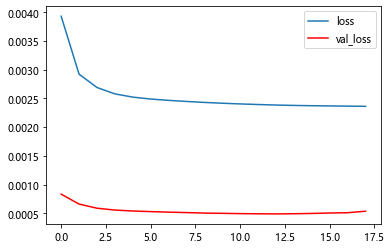

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], c='r')
plt.legend(['loss', 'val_loss'])
plt.show()

In [18]:
# model.save('good_pre_model.h5')
y_pred = model.predict(test_x)

In [19]:
from sklearn.metrics import r2_score
r2_score(test_y, y_pred)

0.9673254575224229

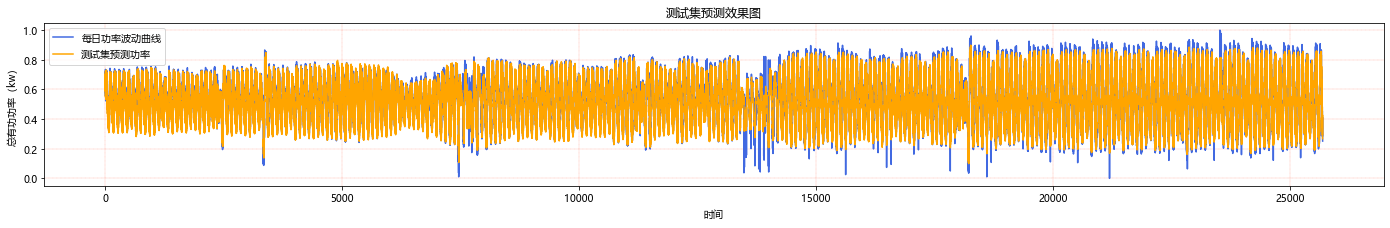

In [20]:
plt.rcParams['font.family'] = ['Microsoft YaHei']
plt.figure(figsize=(24,3))
plt.grid(color = 'tomato', linestyle = '--', linewidth = 0.25)
plt.title('测试集预测效果图')
plt.ylabel('总有功功率（kw）')
plt.xlabel('时间')
plt.plot(test_y[:], color='royalblue', label='每日功率波动曲线')
plt.plot(y_pred[:], color='orange', label='测试集预测功率')
plt.legend()
# plt.savefig('每日功率波动曲线去除异常值前后对比图.svg')

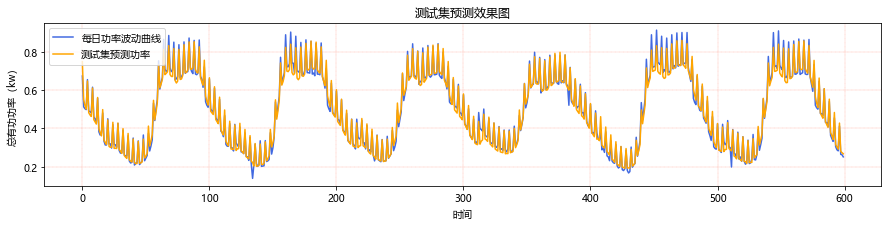

In [33]:
plt.rcParams['font.family'] = ['Microsoft YaHei']
plt.figure(figsize=(15,3))
plt.grid(color = 'tomato', linestyle = '--', linewidth = 0.25)
plt.title('测试集预测效果图')
plt.ylabel('总有功功率（kw）')
plt.xlabel('时间')
plt.plot(test_y[-600:], color='royalblue', label='每日功率波动曲线')
plt.plot(y_pred[-600:], color='orange', label='测试集预测功率')
plt.legend()
# plt.savefig('每日功率波动曲线去除异常值前后对比图.svg')

In [22]:
def predict_all(model, last_x, num=24):
    pred_y=[]
    for i in range(num):
        temp_y = model.predict(last_x)
        pred_y.append(temp_y[0, 0])
        temp_y = np.expand_dims(temp_y, 0)
        last_x = np.concatenate([last_x[:, :, 1:], temp_y], axis=2)
    return np.asarray(pred_y)

In [23]:
last_x = test_x[-1]
last_x = np.expand_dims(last_x, 0)

In [24]:
series_pre = predict_all(model, last_x, num=960)

In [25]:
series = scaler.inverse_transform([series_pre])

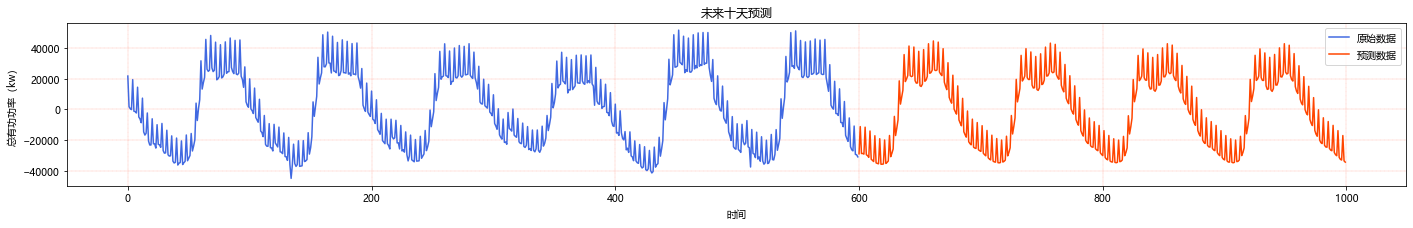

In [26]:
# 原始日周期数据，平滑后数据，与预测数据对比图
begin = 600
plt.rcParams['font.family'] = ['Microsoft YaHei']
plt.figure(figsize=(24,3))
plt.grid(color = 'tomato', linestyle = '--', linewidth = 0.25)
plt.title('未来十天预测')
plt.ylabel('总有功功率（kw）')
plt.xlabel('时间')
plt.plot(range(begin), data_values[-begin:], color='royalblue', label='原始数据')
plt.plot(range(begin, begin+len(series[0,:400])), series[0,:400], color='orangered', label='预测数据')
plt.legend()

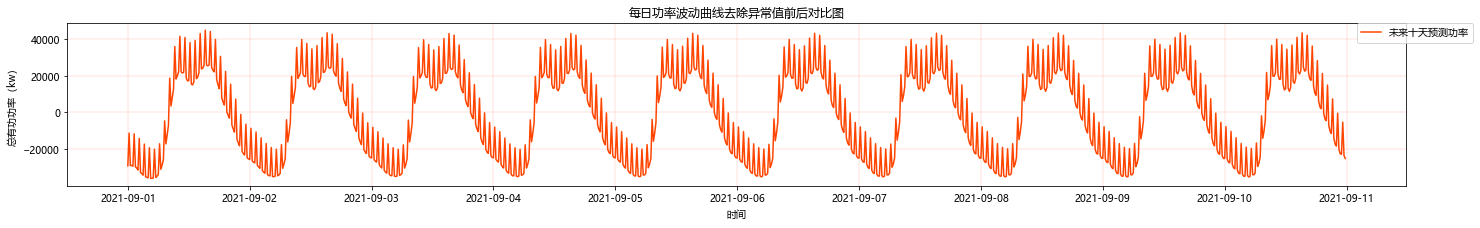

In [28]:
dtip = pd.date_range("2021-09-01", periods=960, freq="15T")
plt.rcParams['font.family'] = ['Microsoft YaHei']
plt.figure(figsize=(24,3))
plt.grid(color = 'tomato', linestyle = '--', linewidth = 0.25)
plt.title('每日功率波动曲线去除异常值前后对比图')
plt.ylabel('总有功功率（kw）')
plt.xlabel('时间')
# plt.plot(dti, data_values, color='lightgreen', label='每日功率波动曲线')
plt.plot(dtip, series[0,:], color='orangered', label='未来十天预测功率')
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
# plt.savefig('每日功率波动曲线去除异常值前后对比图.svg')

In [29]:
predict_daily_change = pd.DataFrame(series[0], index=pd.date_range('2021-09-01 00:00:00', '2021-09-10 23:45:00', freq='15T'), columns=['总有功功率（kw）'])
predict_daily_change.index.name = '数据时间'
# predict_daily_change.to_csv('未来十天日功率波动预测值.csv')

In [30]:
predict_daily_change

,总有功功率（kw）
数据时间,
2021-09-01 00:00:00,-28923.348896
2021-09-01 00:15:00,-11189.470695
2021-09-01 00:30:00,-28729.938715
2021-09-01 00:45:00,-28701.732365
2021-09-01 01:00:00,-29134.538911
...,...
2021-09-10 22:45:00,-22331.686622
2021-09-10 23:00:00,-22716.193705
2021-09-10 23:15:00,-5296.697847
